# FRB RM evolution

In [1]:
import math 
import numpy as np
import pylab as plt
import astropy.units as u
import astropy.constants as Con
import matplotlib as mpl
from scipy.optimize import fmin
from multiprocessing import Pool
from scipy.signal import find_peaks
# import emcee
# import numba
%matplotlib inline

In [16]:
plt.style.use(['science', 'ieee', 'high-vis'])
mpl.rcParams['figure.dpi'] = 300
mpl.rc('pdf', fonttype=42)

## 读取数据

In [3]:
data = np.loadtxt('Data/FRB20201124A_RMclean.txt')

In [4]:
mjd = data[:, 0]
rm = data[:, 1]

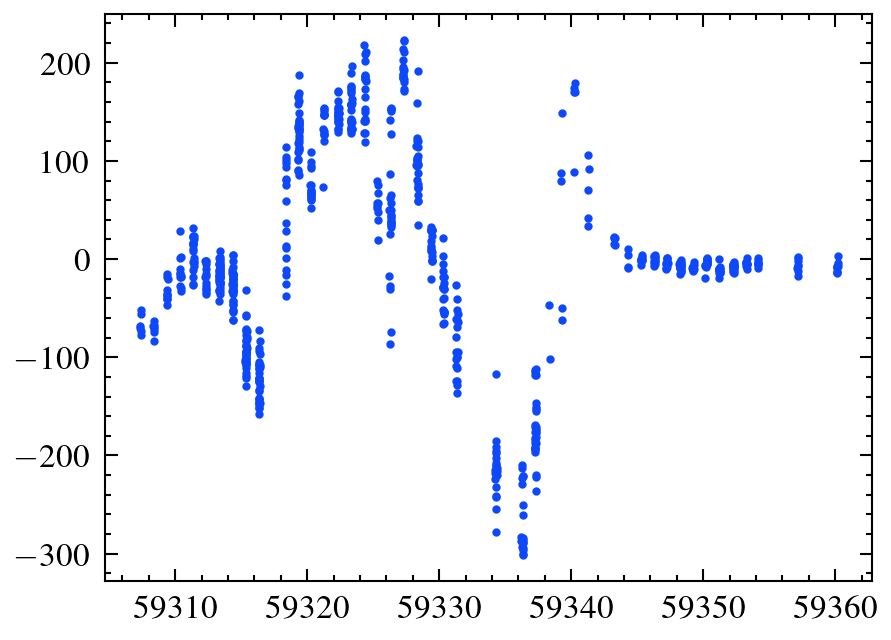

In [5]:
rmmean = rm.mean()
rmf = rm - rmmean
plt.scatter(mjd, rmf, s = 1)

In [6]:
reduceMJD = np.ceil(mjd)
setMJD = np.unique(reduceMJD)
reduceRM = []
reduceRMmax = []
reduceRMmin = []
for i in setMJD:
    idx = (reduceMJD == i)
    reduceRM.append(rmf[idx].mean())
    reduceRMmax.append(rmf[idx].max())
    reduceRMmin.append(rmf[idx].min())
reduceMJD = np.array(setMJD)
reduceRM = np.array(reduceRM)

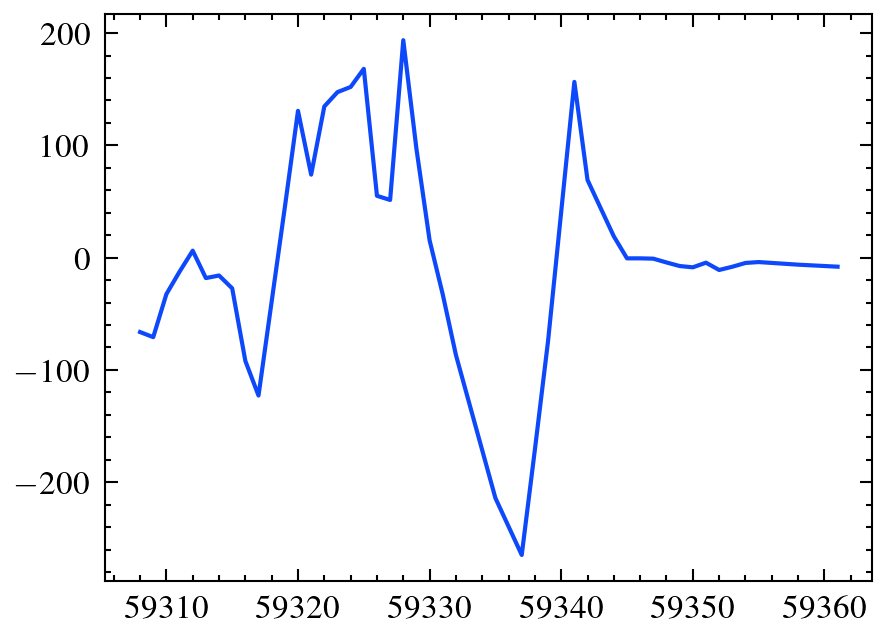

In [7]:
plt.plot(reduceMJD, reduceRM)

## 盘模型

In [8]:
class BeStar():
    '''The Be star model'''
    def __init__(self, Rstar, M_star):
        '''Initial parameters
            params:
                Rstar  : The radius of Be stars (unit: Solar Radius)
                M_star : The mass of Be stars (units: Solar Mass)'''
        self.Rstar = Rstar
        self.M_star = M_star


class powerDisk():
    '''The power-law disk model'''
    def __init__(self, star, rho0, cs, n, radius = 0):
        '''Initial parameters
            params:
                star   : The Be star model
                rho0   : The base density (cgs units)
                cs     : The isothermal sound speed (cgs units)
                n      : The power-law index, expect 2-5'''
        self.star = star
        self.rho0 = rho0
        self.cs = cs
        self.n = n
        self.rhoC = 0
        if (radius):
            self.radius = radius
            self.rhoC = self.rho0 * (radius / self.star.Rstar) ** (-self.n)
        else:
            self.radius = 0
            
        
    def Hr(self, r):
        r = (r * 6.955e8 * u.m).cgs
        results = self.cs * (u.cm / u.s) * np.sqrt(r / (self.star.M_star * Con.M_sun).cgs / Con.G.cgs) * r
        return ((results) / Con.R_sun).cgs
        
    def rho(self, coor):
        r = np.sqrt(coor[:, 0] ** 2 + coor[:, 1] ** 2 + coor[:, 2] ** 2)
        z = coor[:, 2]
        result = self.rho0 * (r / self.star.Rstar) ** (- self.n) * np.exp(- (z / self.Hr(r)) ** 2)
        if (self.radius):
            idx = (result < self.rhoC)
            result[idx] = 0
        idx = (result > self.rho0)
        result[idx] = 0
        return result
    
class windDisk():
    '''The power-law disk model'''
    def __init__(self, star, rho0, n):
        '''Initial parameters
            params:
                star   : The Be star model
                rho0   : The base density (cgs units)
                cs     : The isothermal sound speed (cgs units)
                n      : The power-law index, expect 2-5'''
        self.star = star
        self.rho0 = rho0
        self.n = n
        
    def rho(self, coor):
        r = np.sqrt(coor[:, 0] ** 2 + coor[:, 1] ** 2 + coor[:, 2] ** 2)
        return self.rho0 * (r / self.star.Rstar) ** (- self.n) 
    
    
class magModel():
    '''The magnetar model'''
    def __init__(self, star, B0):
        '''Initial parameters
            params:
                star : The Be star model
                B0   : The base magnetar field (cgs units, G)'''
        self.star = star
        self.B0 = B0
    
    def mag(self, coor):
        r = np.linalg.norm(coor, axis = 1)
        return self.B0 * (coor / self.star.Rstar)  / r.reshape(-1, 1) ** 2

In [9]:
def deriveRM(coor, disk, B, v, length, ratio):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    parB = np.sum(B.mag(samplePoint) * v, axis = 1)
    rm = 8.1e5 * parB * ne
    return (rm.sum() * length / intNum * Con.R_sun).to(u.pc).value

def deriveDM(coor, disk, v, length, ratio):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    return (ne.sum() * length / intNum * Con.R_sun).to(u.pc).value

def deriveTau(coor, disk, v, length, ratio, T, vfre):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    return 8.2e-2 * T ** -1.35 * vfre ** -2.1 * ((ne ** 2).sum() * length / intNum * Con.R_sun).to(u.pc).value

In [10]:
T = 2e4 * u.K
lame = np.sqrt(Con.h ** 2 / 2 / np.pi / Con.m_e / Con.k_B / T)
varep = 13.6 * u.eV
ratio = 2 / lame ** 3 * np.exp(- varep / Con.k_B / T)
ratio = ratio.cgs.value

In [11]:
# Kelper third law
mbe = 8
mns = 1.6
porb = 80
a = (Con.G * (mbe + mns) * Con.M_sun * (porb  * u.day) ** 2 / 4 / math.pi ** 2) ** (1/3) 

In [12]:
star = BeStar(Rstar = 5, M_star = 8)
# sound speed, we adopt T = 2e4 K, mu = 1
cs = np.sqrt(Con.k_B * T / 1 / Con.m_p).cgs.value
disk = powerDisk(star, rho0 = 3e-14, cs = cs, n = 4.)
magn = magModel(star, B0 = 10)
theta = np.linspace(0, 2 * np.pi, 1000)
thetaoff = -1.2* np.pi 
theta = theta + thetaoff
e = 0.75
p = a * (1 - e ** 2)
r = p.to(u.solRad).value / (1 + e * np.cos(theta))
phi = np.pi / 12

In [13]:
# v = np.array([0.95, -0.27, -0.14])
# v = v / np.linalg.norm(v)
ang1 = 3.08#1.353
ang2 = 2.18
v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
v = v / np.linalg.norm(v)
rm = []
dm = []
tau = []
for i in range(1000):
    coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
    rm.append(deriveRM(coor, disk, magn, v, 1000, ratio))
    dm.append(deriveDM(coor, disk, v, 1000, ratio))
    tau.append(deriveTau(coor, disk, v, 1000, ratio, T.value, 1.25))

Text(0.5, 0, 'MJD')

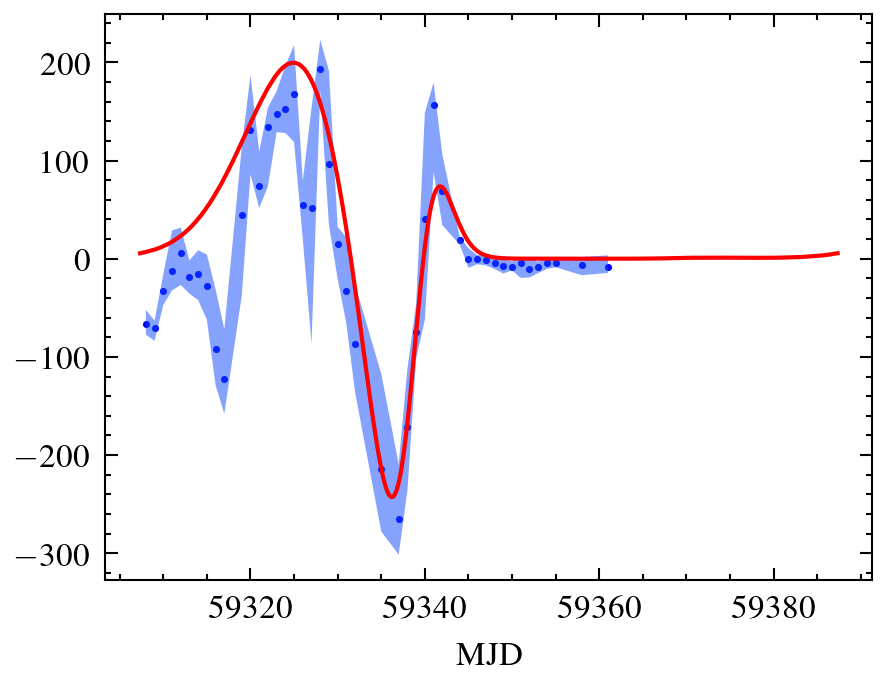

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
mjdf = (( 2 * np.pi - (theta - thetaoff))) / (2 * np.pi) * porb + mjd.min()
plt.plot(mjdf, rm, 'r', label = 'RM')
plt.scatter(reduceMJD, reduceRM, color = 'b', s = 0.5)
thetaf = (mjd - mjd.min()) / porb * 2 * np.pi
plt.fill_between(reduceMJD, reduceRMmax, reduceRMmin, alpha = 0.5)
# plt.scatter(mjd, rmf, s = 1)
plt.xlabel(r'MJD')
# plt.ylabel('$\Delta$RM (rad/m$^2$)')
# plt.savefig("figure/rmevolve.pdf")
# ax2 = ax.twinx()
# ax2.plot(theta, dm, 'r', label = 'DM')
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc = 0)
# plt.ylabel('DM')

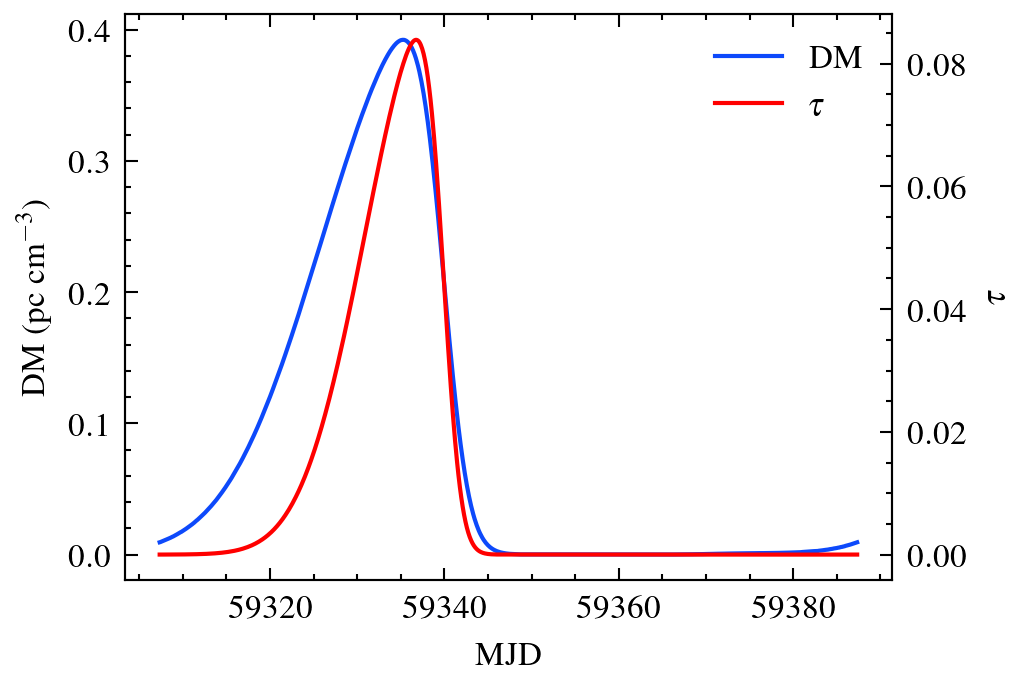

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(mjdf, dm, label = 'DM')
plt.ylabel('DM (pc cm$^{-3}$)')
plt.xlabel("MJD")
ax2 = ax.twinx()
ax2.plot(mjdf, tau, 'r', label = r'$\tau$')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
plt.ylabel(r'$\tau$')

plt.savefig("figure/dmtau.pdf")

### MCMC拟合

In [154]:
def loglike(theta):
    porb, inclineP, offset, e, ang1, ang2 = theta
    porb = porb * 100
    thetaf = (reduceMJD - mjd.min()) / porb * 2 * np.pi
    a = (Con.G * (mbe + mns) * Con.M_sun * (porb  * u.day) ** 2 / 4 / math.pi ** 2) ** (1/3)
    theta = thetaf + offset
    p = a * (1 - e ** 2)
    r = p.to(u.solRad).value / (1 + e * np.cos(theta))
    phi = inclineP
    v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
    v = v / np.linalg.norm(v)
    rm = []
    for i in range(thetaf.shape[0]):
        coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
        rm.append(deriveRM(coor, disk, magn, v, 60, ratio))
    rm = np.array(rm)
    idx = (rm == 0)
    rm[idx] = 0.001
    rm = rm / np.abs(rm).max() * rmf.max()
    return - np.log(((rm - reduceRM) / np.sqrt(np.abs(rm))).sum() ** 2)

def logprior(theta):
    porb, inclineP, offset, e, ang1, ang2 = theta
    porb = porb * 100
    if 60 < porb < 180 and 0 < inclineP < np.pi / 3 and -2 * np.pi < offset < 2 * np.pi and 0 < e < 0.9 and 0 < ang1 < np.pi and 0 < ang2 < 2 * np.pi:
        return loglike(theta)
    return -np.inf

In [155]:
nwalkers = 32
ndim = 6
p0 = np.array([1.4, np.pi / 12, -np.pi / 2.3, 0.7, 1.353, 1.672]) + 1e-1 * np.random.randn(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprior, pool = pool, moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ],)
    sampler.run_mcmc(p0, 5000, progress = True)

100%|██████████| 5000/5000 [16:31<00:00,  5.04it/s]


In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [157]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 6)


In [158]:
from IPython.display import display, Math
labels = ['Porb', 'Phi', 'Offset', 'e', 'Ang1', 'Ang2']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 多个方向画图

In [273]:
def plotBat(ang1, ang2):
            v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
            v = v / np.linalg.norm(v)
            rm = []
            for i in range(1000):
                coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
                rm.append(deriveRM(coor, disk, magn, v, 1000, ratio))
            rm = np.array(rm)
            pN = find_peaks(rm, distance = 90, height = np.mean(rm), prominence = 5)[0].shape[0]
            if (np.abs(rm).max() > 0):
                ditch = (rm.max() - rm.min()) / np.abs(rm).max()            
                if ((pN > 1) and ditch > 1.1):
                    plt.figure()
                    plt.plot(theta, rm)
                    plt.savefig('TestFigure/tmp_p_240_phi_pi_80_e_08_n_4_ang1_{:.2f}_ang2_{:.2f}.jpg'.format(ang1, ang2))  
                    plt.close()

tmp = []
thetaarr = np.linspace(0, np.pi , 50)
phiarr = np.linspace(0, 2 * np.pi, 50)
for i in thetaarr:
    for j in phiarr:
        tmp.append([i, j])
            
with Pool() as pool:
    pool.starmap(plotBat, tmp)

## 星风模型

In [207]:
vw = 1000 * u.km / u.s
rho0 = (1e-10 * Con.M_sun / u.yr) / (4 * np.pi * (star.Rstar * Con.R_sun) ** 2 * vw)
rho0 = rho0.cgs.value
wind = windDisk(star, rho0 = rho0, n = 2.)

In [217]:
def deriveTau(coor, disk, v, length, ratio, T, vfre):
    '''This function derive the RM.
         params:
            coor  : the coordinates of source (units: Solar Radius)
            disk  : the disk model
            B     : the magnetar field model
            v     : the direction vector
            length: the integration length (unit: Solar Radius)'''
    intNum = 1000
    intArr = np.linspace(0, length, intNum)
    samplePoint = coor + intArr.reshape([-1, 1]) * v
    rho = disk.rho(samplePoint)
    n0 = rho / Con.m_p.cgs.value
    ne = (np.sqrt(ratio ** 2 + 4 * ratio * n0) - ratio) / 2
    r = np.sqrt(coor[0] ** 2 + coor[1] ** 2 + coor[2] ** 2)
    Tt = T * (r / 5) ** (-2/3)
    return 8.2e-2 * T ** -1.35 * vfre ** -2.1 * ((ne ** 2).sum() * length / intNum * Con.R_sun).to(u.pc).value

In [225]:
# v = np.array([0.95, -0.27, -0.14])
# v = v / np.linalg.norm(v)
ang1 = 3.08#1.353
ang2 = 2.18#1.672
v = np.array([np.sin(ang1) * np.cos(ang2), np.sin(ang1) * np.sin(ang2), np.cos(ang1)])
v = v / np.linalg.norm(v)
rm = []
dm = []
tau = []
for i in range(1000):
    coor = np.array([r[i] * np.cos(theta[i]), r[i] * np.sin(theta[i]) * np.cos(phi), r[i] * np.sin(theta[i]) * np.sin(phi)])
    rm.append(deriveRM(coor, wind, magn, v, 1000, ratio))
    dm.append(deriveDM(coor, wind, v, 1000, ratio))
    tau.append(deriveTau(coor, wind, v, 1000, ratio, 3e4, 1.25))

In [222]:
np.array(tau).max()

0.004806647317527002

In [223]:
np.array(dm).max()

0.5408409335084865

In [226]:
np.array(rm).max()

3902.844635337813

In [227]:
rho0

4.143888524563531e-17

### 判断盘是否稳定存在

In [21]:
# 活力积分
mu = Con.G * (mbe + mns) * Con.M_sun
v1 = np.sqrt(2 * (mu / (r.min() * Con.R_sun) - mu / (2 * a)))
v2 = np.sqrt(2 * Con.G * mbe * Con.M_sun /  (r.min() * Con.R_sun))
v = v1 + v2

In [22]:
L = 1e34 * u.erg / u.s

In [23]:
nd = 1e-14 * u.g / u.cm ** 3 * (r.min() / 5) ** -4 / Con.m_p
beta = L / (4 * np.pi * Con.c * Con.m_p * nd * (r.min() * Con.R_sun * v) ** 2)

In [24]:
np.sqrt(beta.cgs)

<Quantity 0.70835584>